In [1]:
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import numpy.linalg as la
from __future__ import division
import numpy.random as random
%matplotlib inline

In [2]:
def alpha_pass_unweighted(A, B, pi, obs):
    """
    Parameters:
    A:  A NxN row-stochastic matrix representing the transition probabilities between underlying states.
         A[i,j] = probability of transitioning to state j from state i.
    B:  A NxT row-stochastic matrix representing the probability of seeing an observation given a state.
         B[i,j] = probability of observing j given that we're in state i.
    pi: A Nx1 vector. Represents initial state probability distribution.
    obs: Sequence of observations
    
    Returns:
    alpha: NxT array of alpha values calculated as shown above.
    C:  Tx1 vector of scaling factors for alphas
    """
    N = A.shape[0]
    T = len(obs)
    alpha = np.empty((N,T))
    C = np.zeros(T)
    for i in xrange(N):
        alpha[i,0] = pi[i]*B[i,obs[0]]
        C[0] += alpha[i,0]
    C[0] = 1./C[0]
    #alpha[:,0] *= C[0]

        
    for t in xrange(1,T):
        for i in xrange(N):
            alpha[i,t] = np.dot(alpha[:,t-1], A[:,i])*B[i, obs[t]]
            C[t] += alpha[i, t]
        C[t] = 1/C[t]
        #alpha[:,t] *= C[t]
        
    return alpha

**Problem 1**    
Consider the trained Hidden Markov Problem with ititial conditions given by:   
Let $A = \begin{pmatrix} .7 & .3 \\ .4 & .6 \end{pmatrix}, \ B = \begin{pmatrix} .1 & .4 & .5 \\ .7 & .2 & .1 \end{pmatrix}, \ \pi = \begin{pmatrix} 0 & .1 \end{pmatrix}$

And observation sequence:
$\begin{pmatrix} \mathcal{O}_0 & \mathcal{O}_1 & \mathcal{O}_2 \end{pmatrix} = \begin{pmatrix} 1 & 0 & 2 \end{pmatrix}$

a)  We brute force the probabilites of seeing each possible sequence given our initial state, transition probabilities, and observation probabilities.  Summing all of these will give the total probability of the observed state.

$P(\mathcal{O}, X = H** | \lambda) = 0$, since $P(X_0 = H) = 0$  
$P(\mathcal{O}, X = CHH | \lambda) = (1)(.2)(.4)(.1)(.7)(.5) = .0028$  
$P(\mathcal{O}, X = CHC | \lambda) = (1)(.2)(.4)(.1)(.3)(.1) = .00024$  
$P(\mathcal{O}, X = CCH | \lambda) = (1)(.2)(.6)(.7)(.4)(.5) = .0168$   
$P(\mathcal{O}, X = CCC | \lambda) = (1)(.2)(.6)(.7)(.6)(.1) = .00504$

We obtain the total probability this sequence of observations by summing over all possible combinations of state sequences.

Thus, $P(\mathcal{O}|\lambda) = .0028 + .0024 + .0168 + .00504 = .02488$



b) The Alpha Pass:   
The alpha pass is a much quicker way to calculate the total probability of a sequence of observations.  We do so by calculating the probability of each partial observation sequence up each observation and then iterating to move onto the next.  Define $\alpha_t(i)$ as:   
$$\alpha_t(i) = P(\mathcal{O}_0, \mathcal{O}_1,...,\mathcal{O}_t, x_t = q_i|\lambda)$$
Thus, each alpha becomes:   
$$\alpha_t(j) = \sum_{i=0}^{N-1} \alpha_{t-1}(i)a_{ij}b_i(\mathcal{O}_t)$$ 

Using this, we calculate each $\alpha_t(i)$ as described above.  

$\alpha_0(0) = \pi_0b_0(\mathcal{O}_0) = 0\cdot.5 = 0$         
$\alpha_0(1) = \pi_1b_1(\mathcal{O}_0) = 1\cdot.2 = .2$
$\alpha_1(0) = (\alpha_0(0)\cdot a_{00} + \alpha_0(1)\cdot a_{10})b_0(\mathcal{O}_1) = (0\cdot0.7 + 0.2\cdot0.4)\cdot0.1 = .008$   
$\alpha_1(1) = (0\cdot0.3 + 0.2\cdot0.6)\cdot0.7 = .084$   
$\alpha_2(0) = (.008\cdot0.7 + 0.084\cdot0.4)\cdot0.5 = .0196$  
$\alpha_2(1) = (.008\cdot0.3 + 0.084\cdot0.6)\cdot0.1 = .00528$   
Note that these last two probabilities sum up to $P(\mathcal{O}|\lambda) = .02488$   


c)  The explanations are given in parts (a) and (b) above. Part (a) calculates the total probability of a given observation sequence by summing the joint probabilities the the observation sequence and every possible state sequence.  Part (b) calculates the total probability of ending up in each end state by iteratively estimating the probabilities of arriving at a given end state given the probabilities of being in each previous state (denoted by the $\alpha_t(i)$ terms) and the transition probabilities.  The total probability of the given state sequence is the same in each case.  The results of the alpha pass calculated using our program are given below.

d)  Work factor for method in (a):  $(NT-1)N^T = 40$   
    Work factor for method in (b):  $N(NT-1) = 14$

In [3]:
A = np.array([[.7, .3],[.4, .6]])
B = np.array([[.1, .4, .5], [.7, .2, .1]])
pi = np.array([0., 1.])
obs = np.array([1,0,2])
N = 2
T = 3
alpha = alpha_pass_unweighted(A, B, pi, obs)
print alpha

[[ 0.       0.008    0.0196 ]
 [ 0.2      0.084    0.00528]]


**Problem 2**    
Compare Dynamic Programming and HMM approaches:  

Dynamic Program:  The code below uses dynamic programming to find the most probable path, which turns out to be $\{C, C, H\}$   

HMM Program: To maximize the number of correctly matched states, we simply find the most probable state for each observation.  This yields the sequence:  $\{C, C, H\}$, since we know that the starting state must be $C$.

In [4]:
def dynamicPath(A, B, pi, obs):
    """
    Parameters:
    A:  A NxN row-stochastic matrix representing the transition probabilities between underlying states.
         A[i,j] = probability of transitioning to state j from state i.
    B:  A NxT row-stochastic matrix representing the probability of seeing an observation given a state.
         B[i,j] = probability of observing j given that we're in state i.
    pi: A Nx1 vector. Represents initial state probability distribution.
    obs: Sequence of observations
    
    Returns:
    best_path: Optimal path of hidden states
    """
    T = len(obs)
    N = len(pi)
    
    #We take log probabilities in to allow us to add probabilities (rather than multiply) and to prevent underflow
    A = np.log(A)
    B = np.log(B)
    pi = np.log(pi)
    
    #state_paths: Optimal sequences to arrive at each end state given the data
    #path_probs:  best log probabilities of arriving at each state at a given step in our algorithm    
    state_paths = np.empty((N,T))
    path_probs = np.empty((N,T))
    
    #There is an optimization that doesn't require us to remember probabilities at every state.
    #However, I like this way better because it's easier to tweak for greater functionality.
    
    #Initialize probabilities of being in each initial state
    for i in xrange(N):
        path_probs[i,0] = pi[i]+B[i,obs[0]]
    
    #Now iteratively calculate probabilities of being in each new state given the probabilities of the previous states
    for t in xrange(1,T):
        for j in xrange(N):
            trans_probs = path_probs[:,t-1]+A[:,j]+B[j,obs[t]]
            
            path_probs[j,t] = np.max(trans_probs)
            state_paths[j,t-1] = np.argmax(trans_probs)
    state_paths[:,T-1] = np.arange(N)
            
    best_index = np.argmax(path_probs[:,T-1])
    best_path = state_paths[best_index,:]
    return best_path

In [5]:
print dynamicPath(A, B, pi, obs)

[ 1.  1.  0.]


/Users/davidspencerkartchner/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log


**Problem 3**    
For problem 3, we calculate the total probability of observation sequences using both brute force and using our much more efficient alpha pass.  Below, prob3_a gives the probabilities of every possible length-4 observation sequence using the brute force method while prob3_b gives the probabilities using the alpha pass.  We then show that the arrays are identical (up to machine epsilon) using np.allclose() and show that these probabilities sum to 1, as expected.

In [6]:
def prob3_a(A, B, pi):
    #The sequences defined below represent all possible sequences of underlying states
    sequences = list(product(range(2), repeat=4))
    n = len(sequences)
    for i in xrange(n):
        sequences[i] = list(sequences[i])
    sequences = np.array(sequences)
    
    obs = list(product(range(3), repeat=4))
    N = len(obs)
    for i in xrange(N):
        obs[i] = list(obs[i])
    obs = np.array(obs)
    
    def find_seq_prob(obs, sequences):
        k = len(obs)
        total_prob = 0
        for i in xrange(n):
            seq = sequences[i]
            prob = pi[seq[0]]*B[seq[0], obs[0]]
            for j in xrange(1,k):
                prob *= A[seq[j-1], seq[j]]
                prob *=B[seq[j], obs[j]]
            total_prob += prob
                
        return total_prob
            

    
    probs = np.zeros(N)
    for i in xrange(N):
        probs[i] = find_seq_prob(obs[i], sequences)
    
    return probs

In [7]:
def prob3_b(A, B, pi):
    obs = list(product(range(3), repeat=4))
    n = len(obs)
    for i in xrange(n):
        obs[i] = list(obs[i])
    obs = np.array(obs)
    
    probs = np.zeros(n)
    for i in xrange(n):
        #Note that the sum of the last col of the alpha array will give us the probability of a particular sequence
        alpha = alpha_pass_unweighted(A, B, pi, obs[i])
        prob = np.sum(alpha[:,-1])
        probs[i] = prob
        
    return probs

In [8]:
A = np.array([[.7, .3],[.4, .6]])
B = np.array([[.1, .4, .5], [.7, .2, .1]])
pi = np.array([.6, .4])
probs_a = prob3_a(A, B, pi)
probs_b = prob3_b(A, B, pi)
print "Magic program, are the two estimations the same up to machine epsion? \nAnswer:", np.allclose(probs_a, probs_b)
print "Sum of probabilities = ",np.sum(probs_b)

Magic program, are the two estimations the same up to machine epsion? 
Answer: True
Sum of probabilities =  1.0


**Problem 4**   
$$\pi_i = \frac{\sum_{j=0}^{N-1}\alpha_0(i)a_{ij}b_j(\mathcal{O}_1)\beta_1(j)}{\sum_{j=0}^{N-1}\sum_{i=0}^{N-1}\alpha_0(i)a_{ij}b_j(\mathcal{O}_1)\beta_1(j)}$$

$$a_{ij} = \sum_{t=0}^{T-2}\frac{\alpha_t(i)a_{ij}b_j(\mathcal{O}_{t+1})\beta_{t+1}(j)}{\sum_{j=0}^{N-1}\alpha_t(i)a_{ij}b_j(\mathcal{O}_{t+1})\beta_{t+1}(j)}$$

$$b_{j}(k) = \frac{\sum_{t\in\{0,...,T-1\},\ \mathcal{O}_t = k}\sum_{j=0}^{N-1}\alpha_t(i)a_{ij}b_j(\mathcal{O}_{t+1})\beta_{t+1}(j)}{\sum_{t=0}^{T-1}\sum_{j=0}^{N-1}\alpha_t(i)a_{ij}b_j(\mathcal{O}_{t+1})\beta_{t+1}(j)}$$


**Problem 9**

In [9]:
def alpha_pass(A, B, pi, obs):
    """
    Parameters:
    A:  A NxN row-stochastic matrix representing the transition probabilities between underlying states.
         A[i,j] = probability of transitioning to state j from state i.
    B:  A NxT row-stochastic matrix representing the probability of seeing an observation given a state.
         B[i,j] = probability of observing j given that we're in state i.
    pi: A Nx1 vector. Represents initial state probability distribution.
    obs: Sequence of observations
    
    Returns:
    alpha: NxT array of alpha values calculated as shown above.
    C:  Tx1 vector of scaling factors for alphas
    """
    N = A.shape[0]
    T = len(obs)
    alpha = np.empty((N,T))
    C = np.zeros(T)
    for i in xrange(N):
        alpha[i,0] = pi[i]*B[i,obs[0]]
        C[0] += alpha[i,0]
    C[0] = 1./C[0]
    alpha[:,0] *= C[0]

        
    for t in xrange(1,T):
        for i in xrange(N):
            alpha[i,t] = np.dot(alpha[:,t-1], A[:,i])*B[i, obs[t]]
            C[t] += alpha[i, t]
        C[t] = 1/C[t]
        alpha[:,t] *= C[t]
        
    return alpha, C

print alpha_pass(A, B, pi, obs)

(array([[ 0.75      ,  0.19230769,  0.80842391],
       [ 0.25      ,  0.80769231,  0.19157609]]), array([ 3.125     ,  3.07692308,  3.5326087 ]))


In [10]:
def beta_pass(A, B, pi, obs, C):
    """
    Inputs:
    A:  A NxN row-stochastic matrix representing the transition probabilities between underlying states.
         A[i,j] = probability of transitioning to state j from state i.
    B:  A NxT row-stochastic matrix representing the probability of seeing an observation given a state.
         B[i,j] = probability of observing j given that we're in state i.
    pi: A Nx1 vector. Represents initial state probability distribution.
    obs: Sequence of observations
    
    Returns:
    
    """
    T = len(obs)
    N = len(pi)
    beta = np.empty((N,T))
    d = np.zeros(T)
    beta[:,T-1] = np.ones(N)*C[T-1]
    #d[T-1] = N
    
    for t in xrange(T-2,-1,-1):
        for i in xrange(N):
            beta[i,t] = np.dot(A[i,:], np.multiply(B[:,obs[t+1]],beta[:,t+1]))
            #d[t] += beta[i,t]
        beta[:,t] *= C[t]

    return beta
alpha, C = alpha_pass(A, B, pi, obs)
beta= beta_pass(A, B, pi, obs,C)

In [11]:
def gamma_pass(A, B, obs, alpha, beta):
    """
    Inputs:
    
    A:  A NxN row-stochastic matrix representing the transition probabilities between underlying states.
         A[i,j] = probability of transitioning to state j from state i.
    B:  A NxT row-stochastic matrix representing the probability of seeing an observation given a state.
         B[i,j] = probability of observing j given that we're in state i.
    obs: Sequence of observations
    
    
    Returns:
    gammas:  NxNxT-1 array, where gammas[i,j,t] represents the probability of being in state
        i at time t and transitioning to state j at time t+1
    digammas:  NxT array, where digammas[i,t] represents the probability of being in state i
        at time t given the observation sequence
    """
    N = A.shape[0]
    T = len(obs)
    
    #Initialize array of gammas, as described above
    gammas = np.zeros((N,N,T-1))
    
    #Initialize array of digammas, as described above
    digammas = np.zeros((N,T))
    
    #Iteratively calculate gamma[i,j,t] and scale appropriately
    for t in xrange(T-1):
        for i in xrange(N):
            gammas[i,:,t] = alpha[i,t]*np.multiply(A[i,:], np.multiply(B[:,obs[t+1]], beta[:,t+1]))
        denom = np.sum(gammas[:,:,t])
        gammas[:,:,t] /= denom
        
        #Calculate digammas by summing 
        digammas[:,t] = np.sum(gammas[:,:,t], axis=1)
        
    digammas[:,T-1] = alpha[:,T-1] / np.sum(alpha[:,T-1])
    
    return gammas, digammas

print gamma_pass(A, B, obs, alpha, beta)

(array([[[ 0.21684783,  0.23777174],
        [ 0.4451087 ,  0.02038043]],

       [[ 0.04130435,  0.57065217],
        [ 0.29673913,  0.17119565]]]), array([[ 0.66195652,  0.25815217,  0.80842391],
       [ 0.33804348,  0.74184783,  0.19157609]]))


In [12]:

print 'alpha', alpha
print 'beta',beta
gammas, digammas = gamma_pass(A, B,obs, alpha, beta)

print 'digammas', gammas
print 'gammas', digammas


alpha [[ 0.75        0.19230769  0.80842391]
 [ 0.25        0.80769231  0.19157609]]
beta [[ 2.75815217  4.13043478  3.5326087 ]
 [ 4.22554348  2.82608696  3.5326087 ]]
digammas [[[ 0.21684783  0.23777174]
  [ 0.4451087   0.02038043]]

 [[ 0.04130435  0.57065217]
  [ 0.29673913  0.17119565]]]
gammas [[ 0.66195652  0.25815217  0.80842391]
 [ 0.33804348  0.74184783  0.19157609]]


In [13]:
def beta_gamma_pass(A, B, pi, obs, C):
    N = A.shape[0]
    T = len(obs)
    
    #Initialize array of gammas, as described above
    gammas = np.zeros((N,N,T-1))
    
    #Initialize array of digammas, as described above
    digammas = np.zeros((N,T))
    
    #Iteratively calculate gamma[i,j,t] and scale appropriately
    for t in xrange(T-1):
        for i in xrange(N):
            gammas[i,:,t] = np.multiply(np.multiply(alpha[:,t],A[i,:]), np.multiply(B[:,obs[t]], beta[:,t+1]))
        denom = np.sum(gammas[:,:,t])
        gammas[:,:,t] /= denom
        
        #Calculate digammas by summing 
        digammas[:,t] = np.sum(gammas[:,:,t], axis=(1))
        
    digammas[:,T-1] = alpha[:,T-1] / np.sum(alpha[:,T-1])
    
    return gammas, digammas

In [14]:
def recalculate_parameters(A, B, obs, gammas, digammas):
    """
    Inputs:
    A:  A NxN row-stochastic matrix representing the transition probabilities between underlying states.
         A[i,j] = probability of transitioning to state j from state i.
    B:  A NxT row-stochastic matrix representing the probability of seeing an observation given a state.
         B[i,j] = probability of observing j given that we're in state i.
    gammas:  NxNxT-1 array of gammas[i,j], where gamma[i,j,t] represents the probability of being in state
        i at time t and transitioning to state j at time t+1
    digammas:  NxT array, where digammas[i,t] represents the probability of being in state i
        at time t given the observation sequence
    obs: Sequence of observations
    
    Returns:
    
    """
    N = A.shape[0]
    M = B.shape[1]
    
    #Reestimate pi
    pi = digammas[:,0]
    
    #Reestimate A
    A = np.sum(gammas, axis=2)
    A_divisors = np.sum(digammas[:,:-1], axis=1)
    
    for i in xrange(N):
        A[i,:] /= A_divisors[i]
    
    #Reestimate B
    B_copy = np.copy(B)
    B_divisors = np.sum(digammas, axis=1)
    for i in xrange(N):
        for j in xrange(M):
            #print digammas[i,:]
            #print np.sum(digammas[i,:][obs==j])
            B_copy[i,j] = np.sum(digammas[i,:][np.where(obs==j)])/B_divisors[i]
            
    return A, B_copy, pi


print A
print B
print pi, "\n"
for i in xrange(10):
    alphas, C = alpha_pass(A, B, pi, obs)
    betas = beta_pass(A, B, pi, obs, C)
    gammas, digammas = gamma_pass(A, B, obs, alphas, betas)
    A, B, pi = recalculate_parameters(A, B, obs, gammas, digammas)
    
    print A
    #print B
    #print pi, "\n"


[[ 0.7  0.3]
 [ 0.4  0.6]]
[[ 0.1  0.4  0.5]
 [ 0.7  0.2  0.1]]
[ 0.6  0.4] 

[[ 0.49409333  0.50590667]
 [ 0.56668344  0.43331656]]
[[ 0.30683429  0.69316571]
 [ 0.67017057  0.32982943]]
[[ 0.08580492  0.91419508]
 [ 0.79873764  0.20126236]]
[[ 0.00231581  0.99768419]
 [ 0.92339608  0.07660392]]
[[  4.27956538e-07   9.99999572e-01]
 [  9.87966675e-01   1.20333255e-02]]
[[  2.23227678e-15   1.00000000e+00]
 [  9.99708688e-01   2.91312333e-04]]
[[  1.45245139e-33   1.00000000e+00]
 [  9.99999830e-01   1.69750465e-07]]
[[  3.58108257e-73   1.00000000e+00]
 [  1.00000000e+00   5.76304458e-14]]
[[  7.39061620e-159   1.00000000e+000]
 [  1.00000000e+000   6.64253656e-027]]
[[  0.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   8.82465839e-53]]


In [15]:
def calc_log_prob(C):
    """
    Inputs:
    C:  Array of length T.  Contains the scaling weights calculated in the alpha pass
    
    Returns:
    log_prob:  The log probability of the model based on the weights
    """
    log_prob = np.sum(np.log(C))
    return log_prob

In [16]:
def HMM(A, B, pi, obs):
    maxiters = 100
    iters = 0
    log_prob=0
    old_log_prob = -np.inf
    probabilities = []
    while iters < maxiters:
        old_log_prob = log_prob
        alphas, C = alpha_pass(A, B, pi, obs)
        betas = beta_pass(A, B, pi, obs, C)
        gammas, digammas = gamma_pass(A, B, obs, alphas, betas)
        A, B, pi = recalculate_parameters(A, B, obs, gammas, digammas)
        log_prob = -calc_log_prob(C)
        iters += 1
        probabilities.append(log_prob)
    
    plt.plot(range(iters), probabilities)
    plt.xlabel("Iteration")
    plt.ylabel("Log Probability")
    plt.show()
    return A, B, pi
    

In [17]:
def numberfy(filename):
    """
    Converts text file containing lowercase letters and spaces into numbers
    
    Inputs:
    filename:  Name of the text file to be converted
    
    Returns:
    numberfied_text: Contents of file after being converted to numbers
    """
    f = open(filename, 'r')
    text = f.read()
    numberfied_text = np.array([ord(character) - 97 for character in text])
    numberfied_text[numberfied_text < 0] = 26
    return numberfied_text[0:50000]

In [18]:
def gen_initial_conditions(N, M):
    """
    Inputs:
    N:  Number of underlying (unobserved) states
    M:  Number of observed states
    
    Returns:
    A:  A NxN row-stochastic matrix representing the transition probabilities between underlying states.
         A[i,j] = probability of transitioning to state j from state i.
    B:  A NxT row-stochastic matrix representing the probability of seeing an observation given a state.
         B[i,j] = probability of observing j given that we're in state i.
    pi:  A Nx1 vector. Represents initial state probability distribution.
         
    """
    #Initialize A and B with draws from a uniform distribution and then normalize
    A = random.uniform(size=(N,N))
    A /= np.sum(A, axis=0)
    A = A.T
    B = random.uniform(size=(M,N))
    B /= np.sum(B, axis=0)
    B = B.T
    pi = random.uniform(size=N)
    pi /= np.sum(pi)
    return A, B, pi

In [19]:
def classify_letters(b_new):
    n = b_new.shape[0]
    groups = np.argmax(b_new, axis=0)
    letters = np.array(['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',' '])
    for i in xrange(n):
        print letters[np.where(groups==i)]

**Split letters into two categories**    
Note that here, the model naturally splits the letters into vowells and consonants

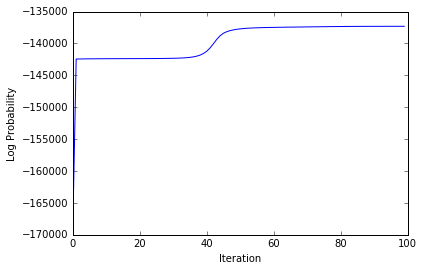

['b' 'c' 'd' 'f' 'g' 'h' 'j' 'k' 'l' 'm' 'n' 'p' 'q' 'r' 's' 't' 'v' 'w'
 'x' 'y' 'z']
['a' 'e' 'i' 'o' 'u' ' ']


In [95]:
A, B, pi = gen_initial_conditions(2, 27)
obs = numberfy('brown.txt')
A_new, B_new, pi_new = HMM(A, B, pi, obs)
classify_letters(B_new)

**Split letters into three categories**   
Here, we get almost all of the vowells in one category, but have 'e' grouped with a few consonants and 'y'

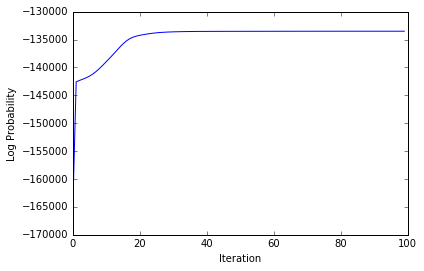

['e' 'g' 'h' 'k' 'y']
['a' 'i' 'o' 'u' ' ']
['b' 'c' 'd' 'f' 'j' 'l' 'm' 'n' 'p' 'q' 'r' 's' 't' 'v' 'w' 'x' 'z']


In [92]:
A, B, pi = gen_initial_conditions(3, 27)
obs = numberfy('brown.txt')
A_new, B_new, pi_new = HMM(A, B, pi, obs)
classify_letters(B_new)

**Split letters into four categories**   
This is perhaps as we expect.  We see all of the voewlls in one category, the space character in a category of its own, and two categories of consonants.

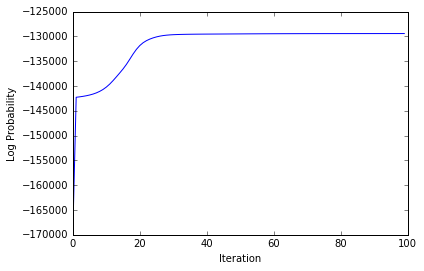

['a' 'e' 'i' 'o' 'u']
[' ']
['b' 'c' 'h' 'j' 'k' 'm' 'p' 'q' 't' 'v' 'w' 'z']
['d' 'f' 'g' 'l' 'n' 'r' 's' 'x' 'y']


In [93]:
A, B, pi = gen_initial_conditions(4, 27)
obs = numberfy('brown.txt')
A_new, B_new, pi_new = HMM(A, B, pi, obs)
classify_letters(B_new)

**Problem 10a**   
Split an encrypted text into vowels and consonants.  

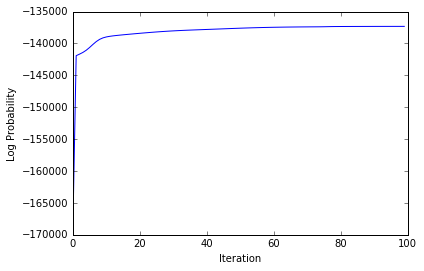

['a' 'b' 'd' 'e' 'f' 'g' 'i' 'j' 'l' 'm' 'n' 'p' 'q' 'r' 's' 't' 'w' 'x'
 'y' 'z' ' ']
['c' 'h' 'k' 'o' 'u' 'v']


In [94]:
A, B, pi = gen_initial_conditions(2, 27)
obs = numberfy('ciphertext.txt')
A_new, B_new, pi_new = HMM(A, B, pi, obs)
classify_letters(B_new)